
# ATMS 523 Module 5: Logistic Regression in Weather & Climate: Interactive Activity

**Goal:** Build and evaluate a logistic regression classifier in a weather/climate context.

This notebook demonstrates:
- Data loading / synthetic generation
- Train/test split
- Logistic Regression (`scikit-learn`)
- Confusion matrix, Accuracy, Precision, Recall
- ROC curve (AUC)
- Precision–Recall curve (PR-AUC)
- **Interactive threshold** to explore metrics trade-offs


In [2]:

# Imports (no seaborn per constraints)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
                             accuracy_score, precision_score, recall_score)
from pathlib import Path

# Local helpers
import sys
sys.path.append(str(Path('../src').resolve()))
from utils import threshold_metrics, roc_pr_curves

# Notebook options
plt.rcParams['figure.figsize'] = (7,4)
plt.rcParams['figure.dpi'] = 120


ImportError: cannot import name 'threshold_metrics' from 'utils' (c:\Users\jared\miniconda3\envs\xarray-climate\Lib\site-packages\utils\__init__.py)


## 1) Data: Use Synthetic Weather-like Predictors or Your Own CSV

Set `USE_SYNTHETIC = True` to simulate features reminiscent of weather predictors, e.g.:
- `cape` (J/kg)
- `pwat` (mm)
- `shear` (m/s)

The target is a binary event (0/1), e.g., convective initiation or severe occurrence.

> To use a CSV instead, switch `USE_SYNTHETIC = False` and update the path and columns.


In [ ]:

USE_SYNTHETIC = True

DATA_PATH = '../data/your_data.csv'  # if using your own data
FEATURES = ['cape','pwat','shear']
TARGET = 'event'

rng = np.random.default_rng(42)

if USE_SYNTHETIC:
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)   # right-skewed CAPE
    pwat  = rng.normal(30, 8, size=n).clip(5, 70) # precipitable water (mm)
    shear = rng.normal(15, 6, size=n).clip(0, 40) # wind shear (m/s)
    X = np.column_stack([cape, pwat, shear])

    # True latent logit with interactions to make it interesting
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv(DATA_PATH)
    assert TARGET in df.columns, f"TARGET '{TARGET}' not in columns"
    assert all([c in df.columns for c in FEATURES]), "Update FEATURES to match your CSV"
    df = df[FEATURES + [TARGET]].dropna()

df.head()


,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1



## 2) Train/Test Split & Model Fit


In [ ]:

X = df[FEATURES].values
y = df[TARGET].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Probabilities on test set
y_prob = clf.predict_proba(X_test)[:,1]

print("Coefficients:", clf.coef_)
print("Intercept:", clf.intercept_)
print("Test set size:", len(y_test))


Coefficients: [[0.00294362 0.0514564  0.0928135 ]]
Intercept: [-6.58369276]
Test set size: 300



## 3) Confusion Matrix @ Default Threshold = 0.5


Accuracy:  0.723
Precision: 0.733
Recall:    0.678


<Figure size 840x480 with 0 Axes>

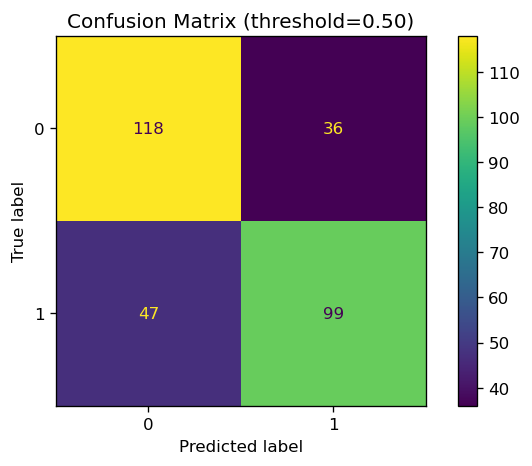

In [ ]:

thr = 0.5
y_pred = (y_prob >= thr).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.3f}\nPrecision: {prec:.3f}\nRecall:    {rec:.3f}")

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix (threshold={thr:.2f})")
plt.show()



## 4) ROC and Precision–Recall Curves


<Figure size 840x480 with 0 Axes>

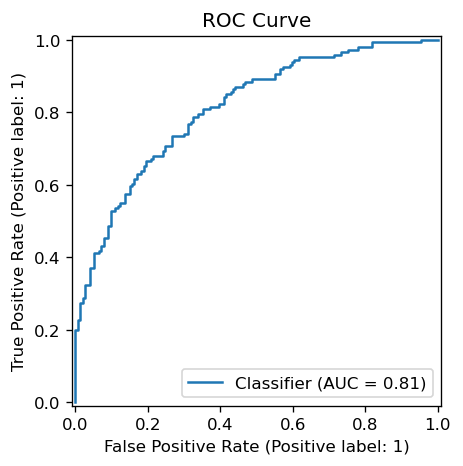

<Figure size 840x480 with 0 Axes>

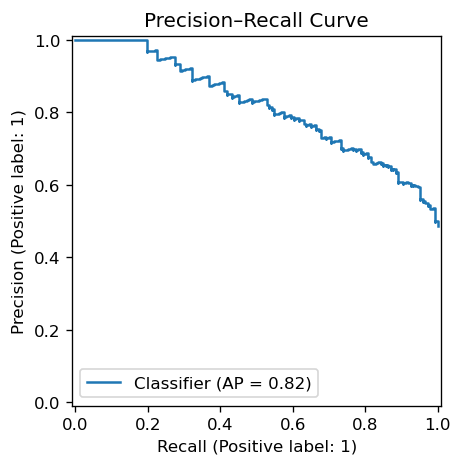

In [ ]:

# ROC
fig = plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve")
plt.show()

# PR
fig = plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision–Recall Curve")
plt.show()



## 5) Interactive Threshold Explorer (ipywidgets)

Move the threshold slider to see how metrics change.


In [ ]:

from ipywidgets import interact, FloatSlider, fixed

def show_metrics(threshold, y_true, y_prob):
    m = threshold_metrics(y_true, y_prob, thr=threshold)
    cm = m['confusion_matrix']
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy:  {m['accuracy']:.3f}  Precision: {m['precision']:.3f}  Recall: {m['recall']:.3f}")
    
    fig = plt.figure()
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix (threshold={threshold:.2f})")
    plt.show()

interact(
    show_metrics,
    threshold=FloatSlider(min=0.0, max=1.0, step=0.01, value=0.5, continuous_update=False),
    y_true=fixed(y_test),
    y_prob=fixed(y_prob)
);


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='threshold', max=1.0, step=0…